In [1]:
# Distribution functions
from scipy.stats import norm


# Load libraries
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

#Libraries for Deep Learning Models
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.layers import LSTM
from keras.wrappers.scikit_learn import KerasRegressor

#Libraries for Statistical Models
import statsmodels.api as sm

#Libraries for Saving the Model
from pickle import dump
from pickle import load

# Time series Models
from statsmodels.tsa.arima_model import ARIMA
#from statsmodels.tsa.statespace.sarimax import SARIMAX

# Error Metrics
from sklearn.metrics import mean_squared_error

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression


#Plotting 
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf

In [2]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
true_alpha = 0.1
true_beta = 0.1
true_sigma0 = 0.2

In [4]:
risk_free_rate = 0.05

In [5]:
def option_vol_from_surface(moneyness, time_to_maturity):
    return true_sigma0 + true_alpha * time_to_maturity + true_beta * np.square(moneyness - 1)

def call_option_price(moneyness, time_to_maturity, option_vol):
    d1=(np.log(1/moneyness)+(risk_free_rate+np.square(option_vol))*time_to_maturity)/(option_vol*np.sqrt(time_to_maturity))
    d2=(np.log(1/moneyness)+(risk_free_rate-np.square(option_vol))*time_to_maturity)/(option_vol*np.sqrt(time_to_maturity))
    N_d1 = norm.cdf(d1)
    N_d2 = norm.cdf(d2)
    
    return N_d1 - moneyness * np.exp(-risk_free_rate*time_to_maturity) * N_d2

In [15]:
N = 10000

Ks = 1+0.25*np.random.randn(N)
Ts = np.random.random(N)
Sigmas = np.array([option_vol_from_surface(k,t) for k,t in zip(Ks,Ts)])
Ps = np.array([call_option_price(k,t,sig) for k,t,sig in zip(Ks,Ts,Sigmas)])

In [16]:
Y = Ps

X = np.concatenate([Ks.reshape(-1,1), Ts.reshape(-1,1), Sigmas.reshape(-1,1)], axis=1)

dataset = pd.DataFrame(np.concatenate([Y.reshape(-1,1), X], axis=1),
                       columns=['Price', 'Moneyness', 'Time', 'Vol'])

In [17]:
dataset.head()

,Price,Moneyness,Time,Vol
0,5.976e-05,1.301,0.108,0.220
1,5.351e-02,1.048,0.171,0.217
2,1.822e-01,0.996,0.641,0.264
3,1.099e-01,1.347,0.858,0.298
4,1.119e-01,0.892,0.058,0.207


In [18]:
pd.set_option('precision', 3)
dataset.describe()

,Price,Moneyness,Time,Vol
count,10000.000,10000.000,1.000e+04,10000.000
mean,0.178,0.998,5.007e-01,0.256
std,0.135,0.249,2.888e-01,0.030
min,0.000,0.145,5.272e-04,0.200
25%,0.075,0.831,2.488e-01,0.231
50%,0.159,1.000,4.981e-01,0.256
75%,0.256,1.166,7.512e-01,0.282
max,0.856,1.955,9.999e-01,0.372


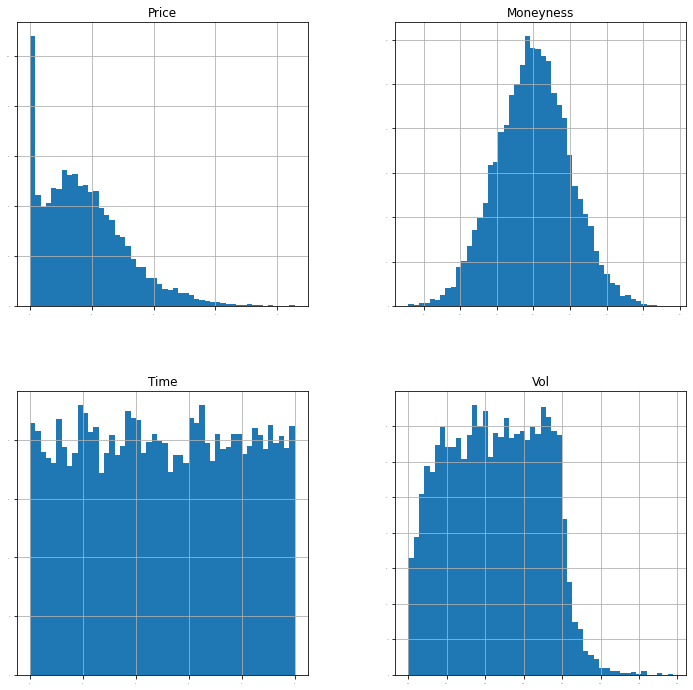

In [19]:
dataset.hist(bins=50, sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
pyplot.show()

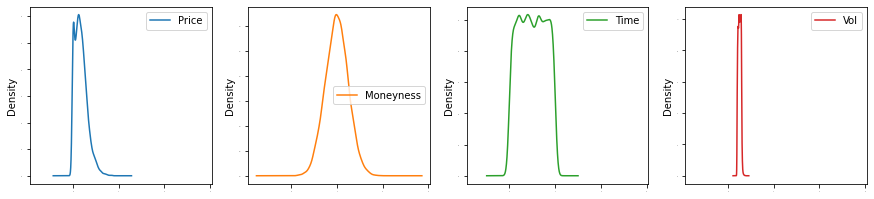

In [20]:
dataset.plot(kind='density', subplots=True, layout=(4,4), sharex=True, legend=True, fontsize=1, figsize=(15,15))
pyplot.show()

<AxesSubplot:title={'center':'Correlation Matrix'}>

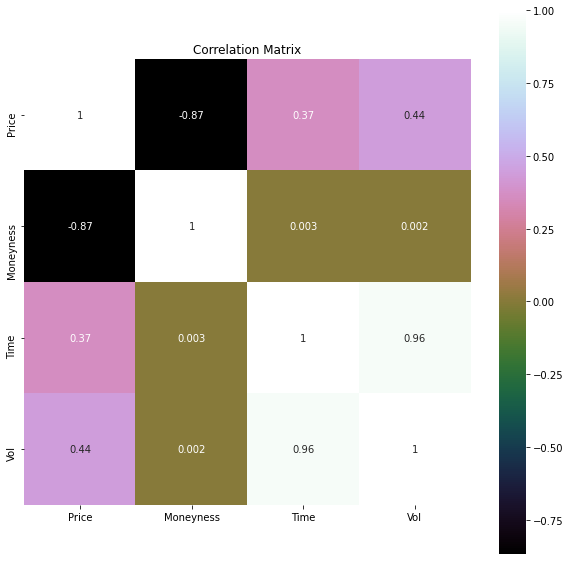

In [21]:
correlation = dataset.corr()
pyplot.figure(figsize=(10,10))
pyplot.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

<Figure size 1080x1080 with 0 Axes>

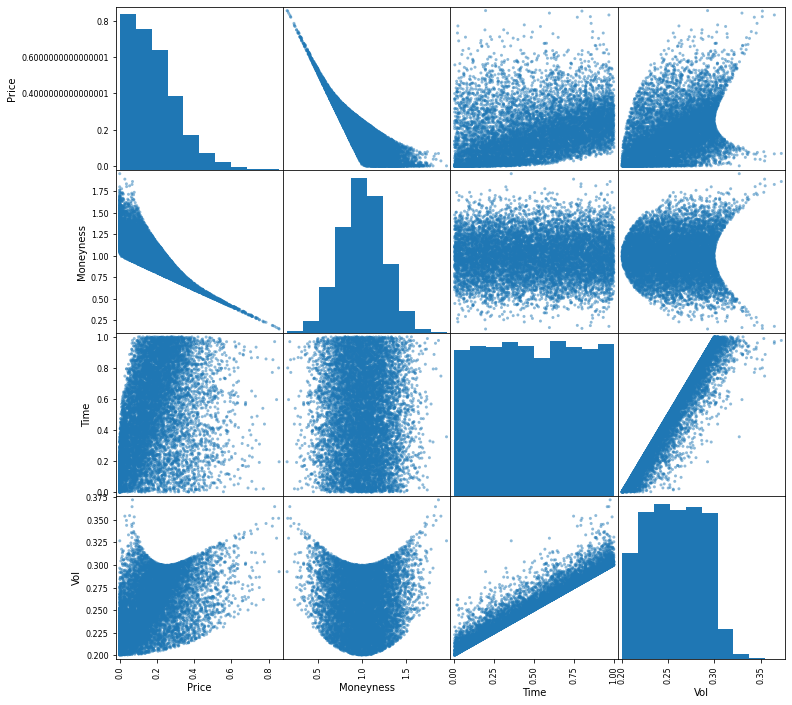

In [22]:
pyplot.figure(figsize=(15,15))
scatter_matrix(dataset,figsize=(12,12))
pyplot.show()

In [23]:
bestfeatures = SelectKBest(k='all', score_func=f_regression)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(['Moneyness', 'Time', 'Vol'])
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
featureScores.nlargest(10,'Score').set_index('Specs')  #print 10 best features

,Score
Specs,
Moneyness,30106.359
Vol,2387.368
Time,1537.751


In [24]:
validation_size = 0.2

train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]

In [25]:
num_folds = 10
seed = 7
# scikit is moving away from mean_squared_error. 
# In order to avoid confusion, and to allow comparison with other models, we invert the final scores
scoring = 'neg_mean_squared_error' 

In [26]:
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))

In [27]:
models.append(('MLP', MLPRegressor()))

In [28]:
# Boosting methods
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
# Bagging methods
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

In [30]:
names = []
kfold_results = []
test_results = []
train_results = []
for name, model in models:
    names.append(name)
    
    ## K Fold analysis:
    
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    #converted mean square error to positive. The lower the beter
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    

    # Full Training period
    res = model.fit(X_train, Y_train)
    train_result = mean_squared_error(res.predict(X_train), Y_train)
    train_results.append(train_result)
    
    # Test results
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    test_results.append(test_result)
    
    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)

LR: 0.000357 (0.000019) 0.000356 0.000386
LASSO: 0.017982 (0.001063) 0.017976 0.019847
EN: 0.017982 (0.001063) 0.017976 0.019847
KNN: 0.000016 (0.000008) 0.000009 0.000023
CART: 0.000010 (0.000000) 0.000000 0.000009
SVR: 0.004398 (0.000092) 0.004391 0.004375
MLP: 0.000038 (0.000026) 0.000037 0.000032
ABR: 0.000603 (0.000019) 0.000595 0.000572
GBR: 0.000020 (0.000001) 0.000017 0.000020
RFR: 0.000002 (0.000001) 0.000000 0.000002
ETR: 0.000001 (0.000001) 0.000000 0.000001


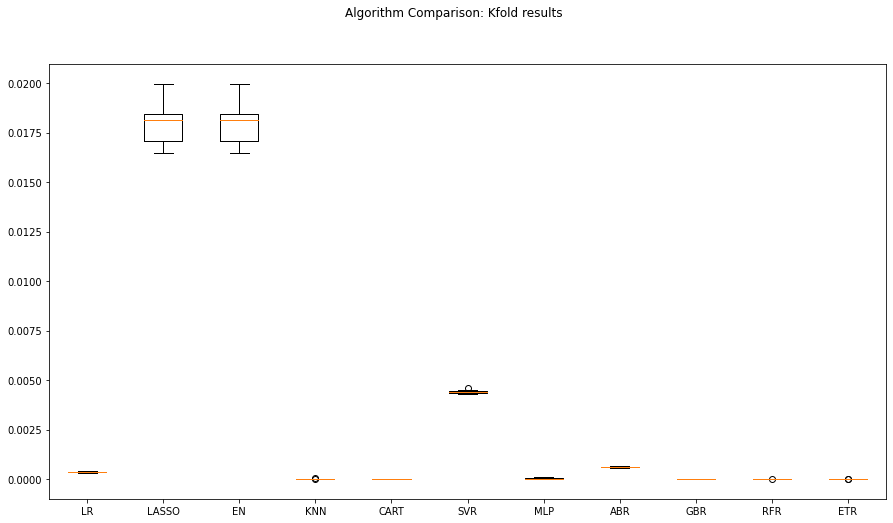

In [31]:
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison: Kfold results')
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()

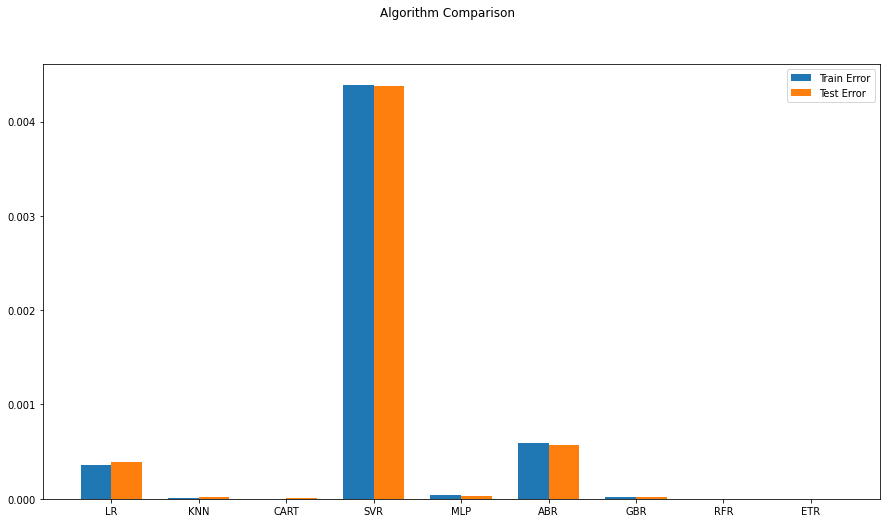

In [32]:
# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names)-2)  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results[0:1] + train_results[3:],  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results[0:1] + test_results[3:], width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names[0:1] + names[3:])
pyplot.show()

In [34]:
'''
hidden_layer_sizes : tuple, length = n_layers - 2, default (100,)
    The ith element represents the number of neurons in the ith
    hidden layer.
'''
param_grid={'hidden_layer_sizes': [(20,), (50,), (20,20), (20, 30, 20)]}
model = MLPRegressor()
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.000033 using {'hidden_layer_sizes': (20, 30, 20)}
-0.000351 (0.000252) with: {'hidden_layer_sizes': (20,)}
-0.000237 (0.000384) with: {'hidden_layer_sizes': (50,)}
-0.000140 (0.000259) with: {'hidden_layer_sizes': (20, 20)}
-0.000033 (0.000036) with: {'hidden_layer_sizes': (20, 30, 20)}


In [35]:
# prepare model
model_tuned = MLPRegressor(hidden_layer_sizes=(20, 30, 20))
model_tuned.fit(X_train, Y_train)

MLPRegressor(hidden_layer_sizes=(20, 30, 20))

In [36]:
# estimate accuracy on validation set
# transform the validation dataset
predictions = model_tuned.predict(X_test)
print(mean_squared_error(Y_test, predictions))

2.5722878270852802e-05


In [37]:
X = X[:, :2]

In [38]:
validation_size = 0.2

train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]

In [39]:
num_folds = 10
seed = 7
# scikit is moving away from mean_squared_error. 
# In order to avoid confusion, and to allow comparison with other models, we invert the final scores
scoring = 'neg_mean_squared_error' 

In [40]:
models = []
models.append(('LR', LinearRegression()))
#models.append(('LASSO', Lasso()))
#models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))

In [41]:
models.append(('MLP', MLPRegressor()))

In [42]:
# Boosting methods
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
# Bagging methods
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

In [44]:
names = []
kfold_results = []
test_results = []
train_results = []
for name, model in models:
    names.append(name)
    
    ## K Fold analysis:
    
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    #converted mean square error to positive. The lower the beter
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    

    # Full Training period
    res = model.fit(X_train, Y_train)
    train_result = mean_squared_error(res.predict(X_train), Y_train)
    train_results.append(train_result)
    
    # Test results
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    test_results.append(test_result)
    
    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)

LR: 0.002056 (0.000180) 0.002053 0.002259
KNN: 0.000016 (0.000008) 0.000009 0.000023
CART: 0.000010 (0.000001) 0.000000 0.000009
SVR: 0.005954 (0.000105) 0.005934 0.005825
MLP: 0.000054 (0.000037) 0.000071 0.000073
ABR: 0.000624 (0.000030) 0.000612 0.000602
GBR: 0.000022 (0.000001) 0.000018 0.000020
RFR: 0.000002 (0.000000) 0.000000 0.000002
ETR: 0.000001 (0.000001) 0.000000 0.000001


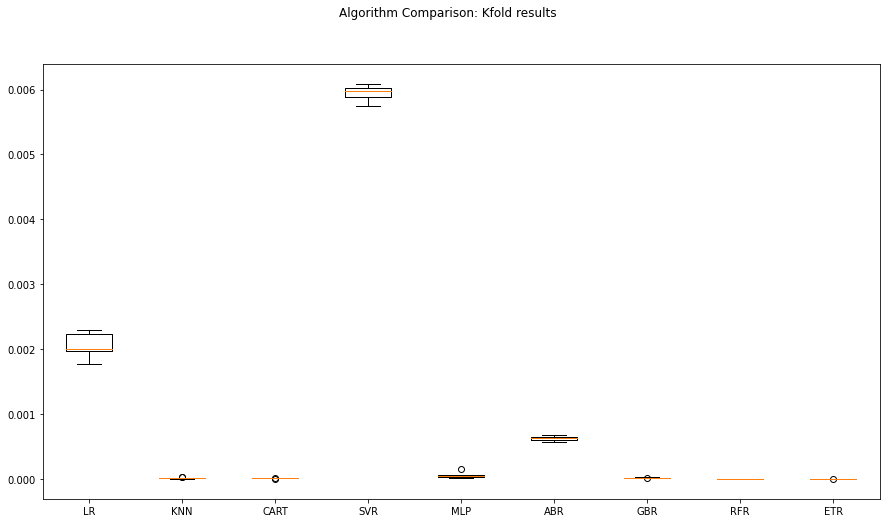

In [45]:
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison: Kfold results')
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()

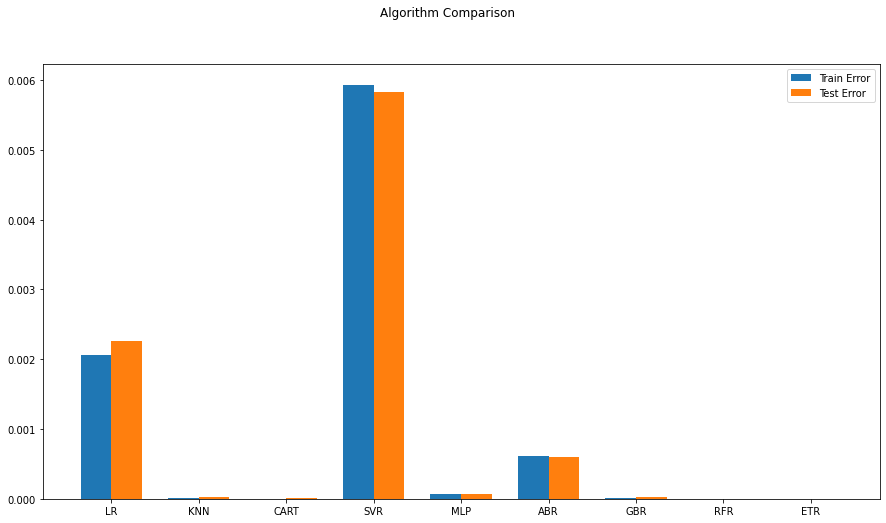

In [46]:
# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()